In [33]:
import boto3
import sagemaker
from pyathena import connect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from geopy.geocoders import Nominatim
import geopandas
import os


### Create and Verify Database

In [34]:
# Make athena db
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [35]:
ingest_create_athena_db_passed = False

In [36]:
# Set db name
database_name = "crops"

In [37]:
# Set S3 staging directory - temporary directory used for athena
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [38]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [39]:
# Create the Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS crops


""


In [40]:
# Make sure it was created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,crops
1,default


In [41]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [42]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena for Merged DB

In [43]:
# Athena parameters
table_name_csv = "merged_df"
s3_private_path_csv = "s3://sagemaker-studio-998234604495-nyhifbo32oo/merged/"
table_name_parquet = "merged_df_parquet"
s3_path_parquet = "s3://sagemaker-studio-998234604495-nyhifbo32oo/parquet/"


In [44]:
# Create athena table based on merged data
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        Area string,
        Item string,
        year integer,
        production integer,
        nitrogen integer,
        phosphate integer,
        potassium integer,
        value float,
        avg_rain float,
        avg_temp float,
        total_value_usd float
        
        
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_csv
)

pd.read_sql(statement, conn)

""


In [45]:
# Look at the dataset
statement = """SELECT * FROM {}.{}
    LIMIT 5""".format(
    database_name, table_name_csv
)

print(statement)

test= pd.read_sql(statement, conn)
test.head()

SELECT * FROM crops.merged_df
    LIMIT 5


,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,Albania,Apples,1991,10000,22300,7700,1300,None,1485.0,15.36,None
1,Albania,Apricots,1991,1200,22300,7700,1300,None,1485.0,15.36,None
2,Albania,Barley,1991,3323,22300,7700,1300,None,1485.0,15.36,None
3,Albania,Beans dry,1991,12844,22300,7700,1300,None,1485.0,15.36,None
4,Albania,Broad beans and horse beans green,1991,0,22300,7700,1300,None,1485.0,15.36,None


### Convert to Parquet - Haven't got this to work, may be worth exploring to reduce costs

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['item']) AS
SELECT area,
        item,
        year,
        production,
        nitrogen,
        phosphate,
        potassium,
        value,
        avg_rain,
        avg_temp,
        total_value_usd  
FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name_csv
)

pd.read_sql(statement, conn)

# Exploratory Data Analysis

In [46]:
### Save as df to potentially save cost
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name_csv
)

df= pd.read_sql(statement, conn)
df.head()

,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,Egypt,Apples,1992,260797.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN
1,Egypt,Apricots,1992,44833.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN
2,Egypt,Artichokes,1992,42820.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN
3,Egypt,Bananas,1992,396497.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN
4,Egypt,Barley,1992,234000.0,743742.0,104000.0,29700.0,148.7,51.0,20.09,34795800.0


In [47]:
print("There are", df.shape[0], "rows in the data frame and", df.shape[1], "columns")

There are 113454 rows in the data frame and 11 columns


## Adding in Geographic Data
Since we're using location as a predictor, we'll need to grab the coordinates of each country. There are also regions that we'll need to delete

In [48]:
# Functions to find coordinates
geolocater = Nominatim(user_agent="geoapiExercise")
def geolocate_lat(area):
    try:
        # Center of country
        loc = geolocater.geocode(area)
        # Return coords
        return (loc.latitude)
    except:
        return np.nan
    
def geolocate_long(area):
    try:
        # Center of country
        loc = geolocater.geocode(area)
        # Return coords
        return (loc.longitude)
    except:
        return np.nan

In [49]:
# Get the coordinates and build df for them
countries = df['area'].unique()
countries = pd.Series(countries)

latitudes = countries.apply(geolocate_lat)
longitudes = countries.apply(geolocate_long)

coord = pd.DataFrame(list(zip(countries, latitudes, longitudes)),
             columns=['area', 'lat', 'long'])

In [50]:
# Merge our data
df = pd.merge(df, coord, left_on=['area'], right_on=['area'], how="inner")
df.head()

,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd,lat,long
0,Egypt,Apples,1992,260797.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN,26.254049,29.267547
1,Egypt,Apricots,1992,44833.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN,26.254049,29.267547
2,Egypt,Artichokes,1992,42820.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN,26.254049,29.267547
3,Egypt,Bananas,1992,396497.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN,26.254049,29.267547
4,Egypt,Barley,1992,234000.0,743742.0,104000.0,29700.0,148.7,51.0,20.09,34795800.0,26.254049,29.267547


## NA Analysis

In [51]:
nan_count = df.isna().sum()
print(nan_count)

area                   0
item                   0
year                   0
production          2570
nitrogen            2149
phosphate           4453
potassium           5433
value              40675
avg_rain               0
avg_temp               0
total_value_usd    40918
lat                    0
long                3322
dtype: int64


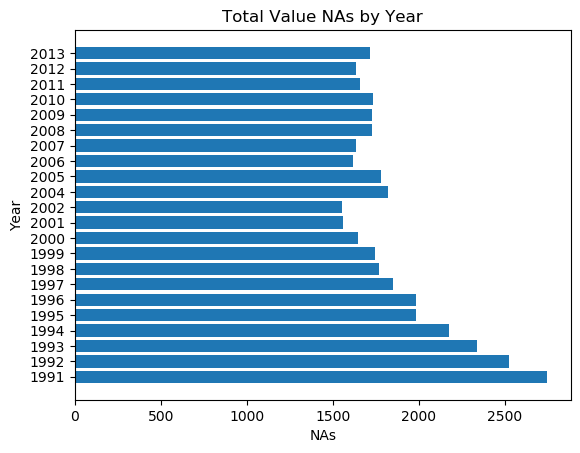

In [52]:
# By Year
na_year = df.total_value_usd.isnull().groupby(df['year']).sum().astype(int).reset_index(name="count")
na_year['year'] = na_year['year'].astype(object)

bars = na_year['year']
height = na_year['count']
y_pos = np.arange(len(bars))

plt.clf()
plt.barh(y_pos, height)

plt.title("Total Value NAs by Year")
plt.ylabel("Year")
plt.xlabel("NAs")
plt.yticks(y_pos, bars)
plt.show()

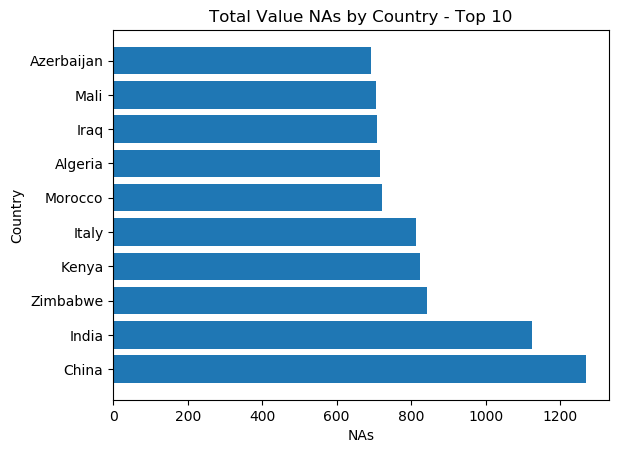

In [53]:
# By Country
na_country = df.total_value_usd.isnull().groupby(df['area']).sum().astype(int).reset_index(name="count")
na_country = na_country.sort_values(by=['count'], ascending=False).head(10)


bars = na_country['area']
height = na_country['count']
y_pos = np.arange(len(bars))

plt.clf()
plt.barh(y_pos, height)

plt.title("Total Value NAs by Country - Top 10")
plt.ylabel("Country")
plt.xlabel("NAs")
plt.yticks(y_pos, bars)
plt.show()

It looks like India may have some issues if we remove the NAs. We'll check to see how many observations are left when we remove NAs.

Looks like we'll still be fine leaving India in. 

In [54]:
df_nona = df.dropna()
df_nona_india = df_nona[df_nona['area'] == "India"]
df_india = df[df['area'] == "India"]

print("India loses", df_india.shape[0] - df_nona_india.shape[0], "observations when we take out NAs leaving us with", df_nona_india.shape[0], "observations left for the country")

India loses 1125 observations when we take out NAs leaving us with 437 observations left for the country


### Final clean before modeling 
As we'll see below, fertilizers are fairly related to each other so we should be able to impute those missing values in a pipeline later. It likely isn't appropriate to impute the large number of missing total_value_usd's, so we will delete those. We also should not need production, value, or year for our final modeling (not doing time series) so we'll create another modeling dataframe here.

In [55]:
df_clean = df[df['total_value_usd'].notna()]

# Note - we still expect to have nas for fertilizers since we're imputing those
nan_count = df_clean.isna().sum()
print(nan_count)

area                  0
item                  0
year                  0
production            0
nitrogen            173
phosphate          1376
potassium          1615
value                 0
avg_rain              0
avg_temp              0
total_value_usd       0
lat                   0
long               1978
dtype: int64


In [56]:
df_model = df_clean.drop(columns = ['year', 'production', 'value'], axis = 1)

## Target Variable - total_value_usd 
The target variable is the production (in tonnes) multiplied by the value (United States Dollar per tonne).

### Distribution 
Our target is very skewed to the right. Not suprising given that some crops likely produce a lot more value than most (for example corn in the USA is likely very high valued). Need to consider scaling after splitting.

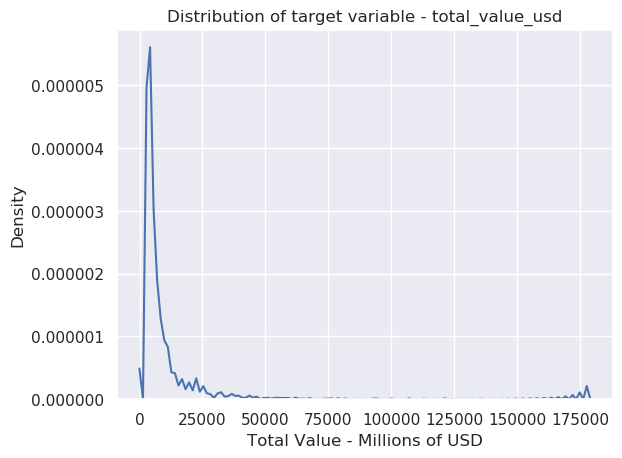

In [57]:
sns.set(style = "darkgrid")
sns.distplot(a = df_clean['total_value_usd']/1_000_000, hist = False, kde = True, rug = False)
plt.xlabel("Total Value - Millions of USD")
plt.ylabel("Density")
plt.title("Distribution of target variable - total_value_usd")
plt.show()

## Numeric Predictors 
The numeric predictors include the fertilizers used for agricultural purposes (nitrogen, phosphate, and potassium) and the weather featrues (avg_temp and avg_rain)

#### Fertilizer Distributions 
Still skewed heavily to the right, we'll likely need to make pipeline to standardize all numeric features

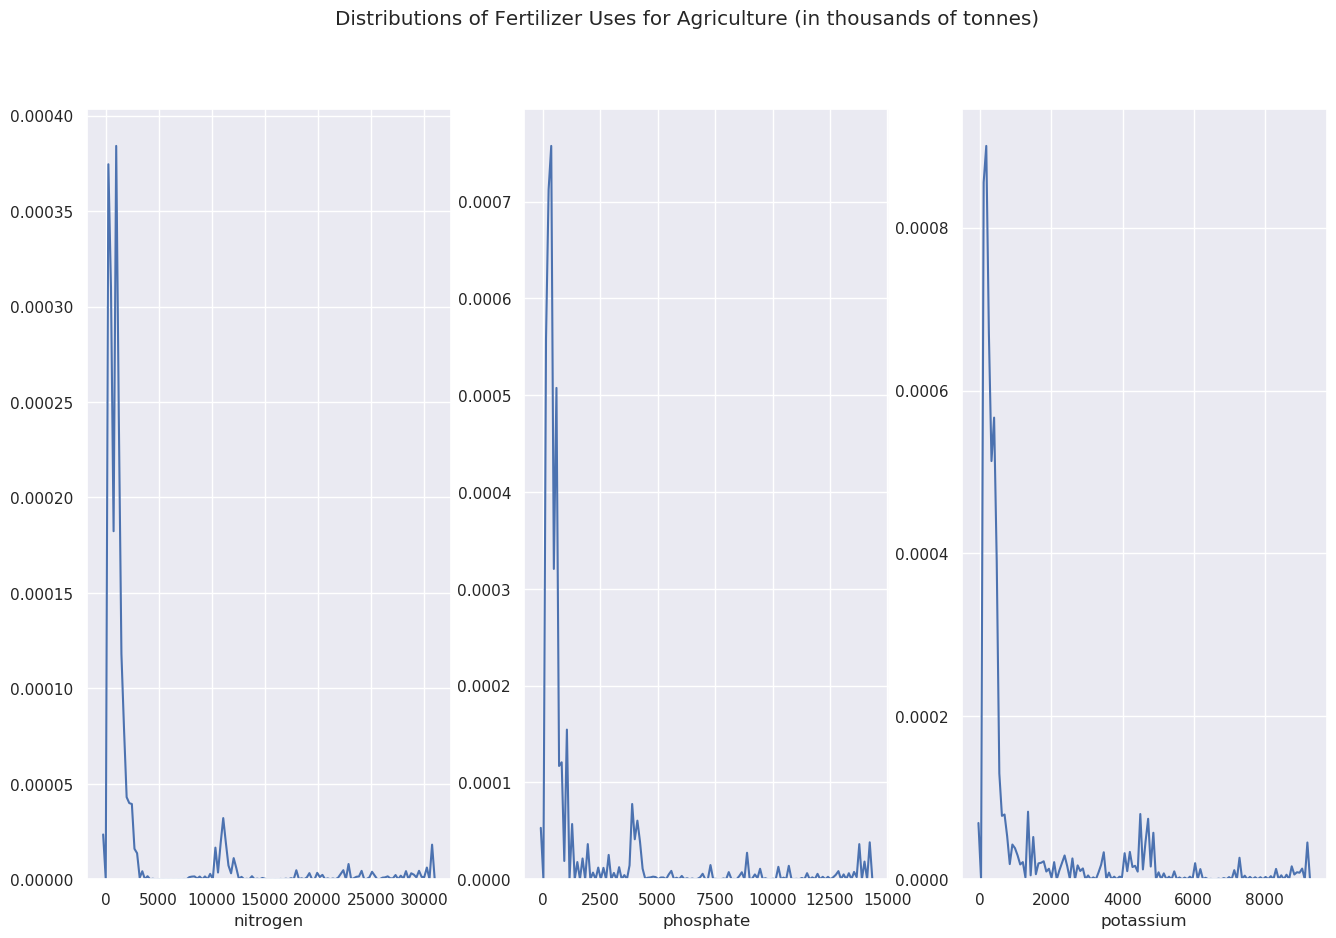

In [58]:
fig, axes = plt.subplots(1,3, figsize=(16,10))

fig.suptitle("Distributions of Fertilizer Uses for Agriculture (in thousands of tonnes)")

sns.distplot(ax = axes[0], a = df_clean['nitrogen']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df_clean['phosphate']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[2], a = df_clean['potassium']/1_000, hist = False, kde = True, rug = False)

plt.show()


#### Weather Predictors 
These Look a lot better than other variables, regardless a standardization pipeline that works on all numeric features is still probbaly the most efficient option.

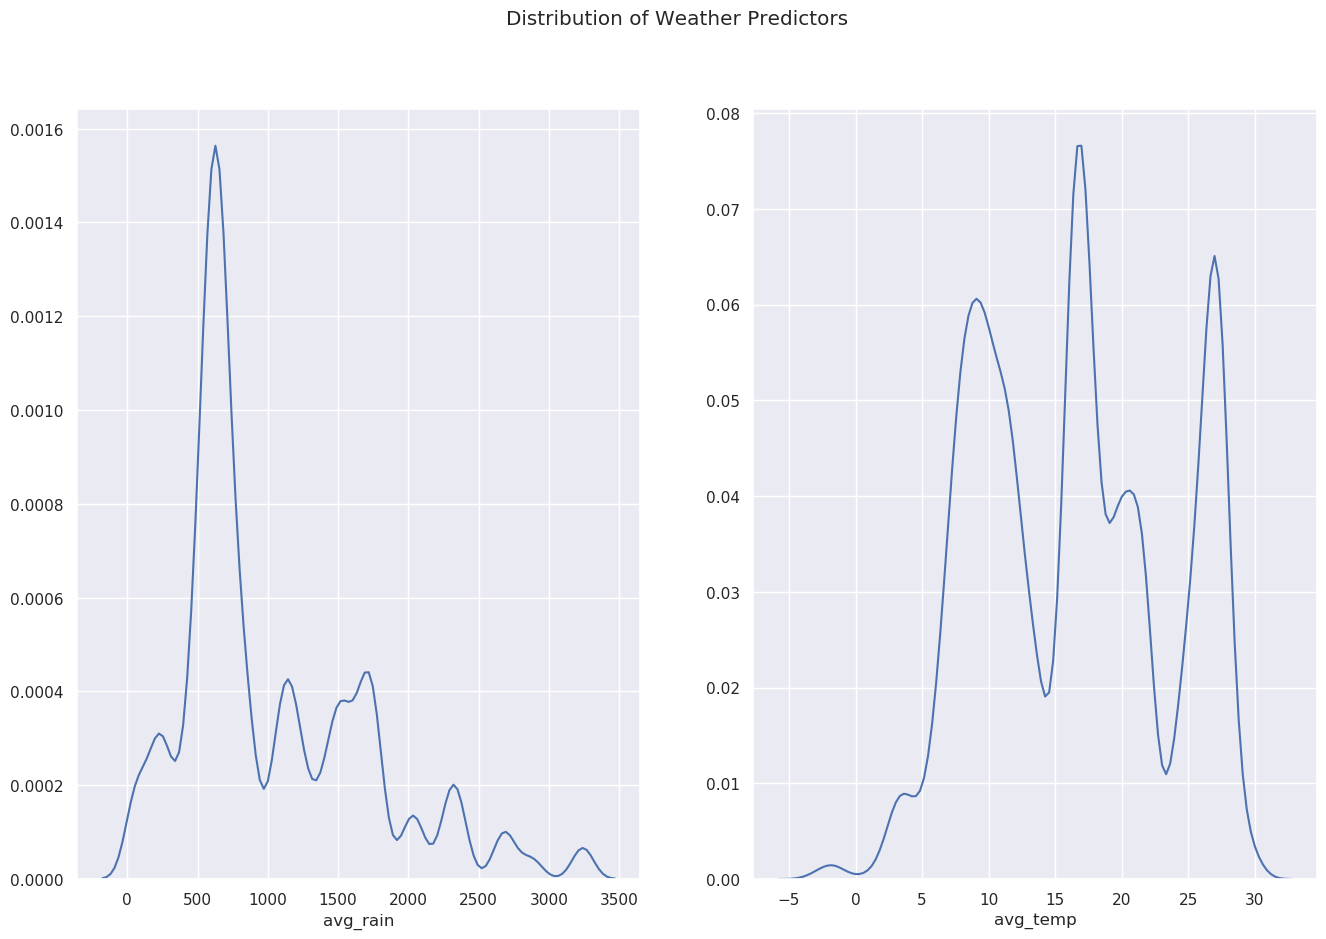

In [59]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

fig.suptitle("Distribution of Weather Predictors")

sns.distplot(ax = axes[0], a = df_clean['avg_rain'], hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df_clean['avg_temp'], hist = False, kde = True, rug = False)

plt.show()

## Correlation Matrix 

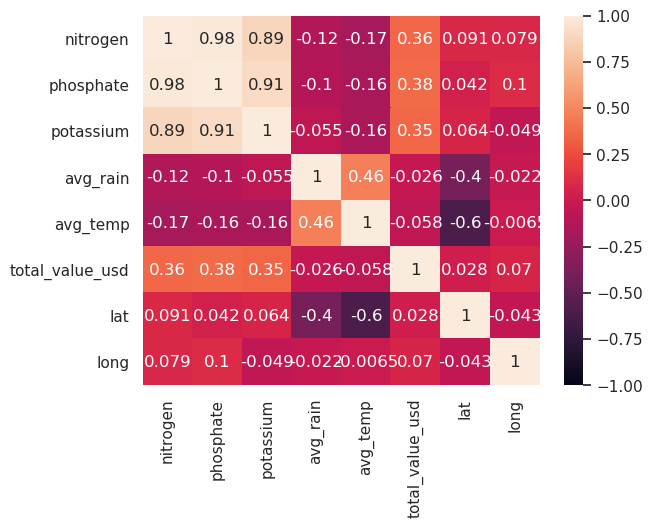

In [60]:
df_numeric = df_clean.select_dtypes(['int64', 'float64'])
df_numeric = df_numeric.drop(columns=['year', 'production', 'value'], axis=1)
df_numeric_nona = df_numeric.dropna()


plt.clf()
sns.heatmap(df_numeric_nona.corr(), vmin= -1, vmax=1, annot=True)
plt.show()

## Maps
Doing the maps down here since we have NAs sorted out now.

Bring in our world data

In [61]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_geo = pd.merge(df, world, how="inner", left_on=['area'], right_on=['name']).reset_index()
world_geo.head()

,index,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd,lat,long,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,0,Egypt,Apples,1992,260797.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN,26.254049,29.267547,97041072,Africa,Egypt,EGY,1105000.0,"POLYGON ((36.86623 22.00000, 32.90000 22.00000..."
1,1,Egypt,Apricots,1992,44833.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN,26.254049,29.267547,97041072,Africa,Egypt,EGY,1105000.0,"POLYGON ((36.86623 22.00000, 32.90000 22.00000..."
2,2,Egypt,Artichokes,1992,42820.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN,26.254049,29.267547,97041072,Africa,Egypt,EGY,1105000.0,"POLYGON ((36.86623 22.00000, 32.90000 22.00000..."
3,3,Egypt,Bananas,1992,396497.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN,26.254049,29.267547,97041072,Africa,Egypt,EGY,1105000.0,"POLYGON ((36.86623 22.00000, 32.90000 22.00000..."
4,4,Egypt,Barley,1992,234000.0,743742.0,104000.0,29700.0,148.7,51.0,20.09,34795800.0,26.254049,29.267547,97041072,Africa,Egypt,EGY,1105000.0,"POLYGON ((36.86623 22.00000, 32.90000 22.00000..."


In [62]:
val_country = world_geo.groupby(by="area")["total_value_usd"].sum()
geos = world_geo['geometry'].unique()

val_country = pd.DataFrame(list(zip(countries,val_country, geos)),
                           columns=['country', 'value', 'geometry'])
val_country.head()

gdf_value = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

gdf_value.head()

,country,value,geometry
0,Egypt,2.519577e+10,"POLYGON ((36.86623 22.00000, 32.90000 22.00000..."
1,El Salvador,1.668569e+11,"POLYGON ((-89.35333 14.42413, -89.05851 14.340..."
2,Eritrea,3.040496e+10,"POLYGON ((36.42951 14.42211, 36.32322 14.82249..."
3,Estonia,3.898487e+11,"POLYGON ((27.98113 59.47537, 27.98112 59.47537..."
4,Finland,1.536307e+10,"POLYGON ((28.59193 69.06478, 28.44594 68.36461..."


In [63]:
gdf_value['value'] = gdf_value[['value']]/1_000_000_000_000

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 640x480 with 0 Axes>

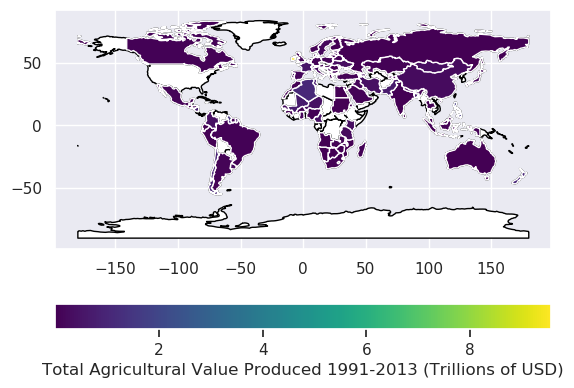

In [64]:
plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_value.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Total Agricultural Value Produced 1991-2013 (Trillions of USD)",
                            'orientation':"horizontal"})
plt.show()



### Avg. Temperatures


/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 640x480 with 0 Axes>

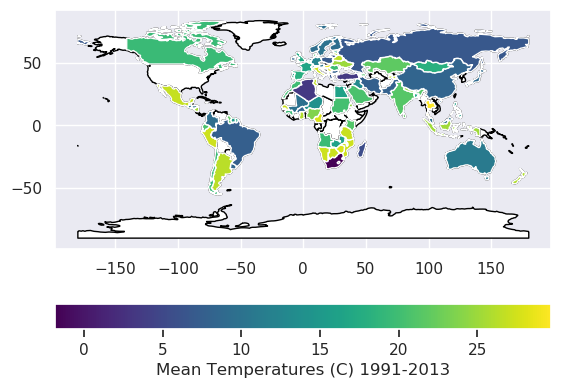

In [65]:
# Taking mean of mean should be okay since our sample sizes are the same
temps = world_geo.groupby(by="area")["avg_temp"].mean()
geos = world_geo['geometry'].unique()

val_country = pd.DataFrame(list(zip(countries,temps, geos)),
                           columns=['country', 'value', 'geometry'])

gdf_temp = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_temp.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Temperatures (C) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Avg. Rainfall

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 640x480 with 0 Axes>

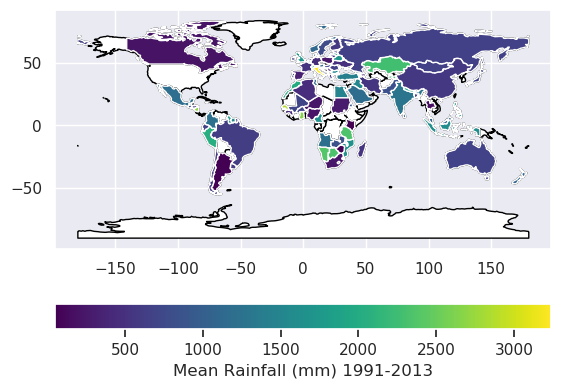

In [66]:
# Taking mean of mean should be okay since our sample sizes are the same
rain = world_geo.groupby(by="area")["avg_rain"].mean()
geos = world_geo['geometry'].unique()

val_country = pd.DataFrame(list(zip(countries,rain, geos)),
                           columns=['country', 'value', 'geometry'])

gdf_rain = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_rain.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Rainfall (mm) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Nitrogen for Ag Use

In [67]:
nit = world_geo.groupby(by="area")["nitrogen"].mean()
geos = world_geo['geometry'].unique()

val_country = pd.DataFrame(list(zip(countries,nit, geos)),
                           columns=['country', 'value', 'geometry'])

gdf_nitrogen = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)



In [68]:
gdf_nitrogen['value'] = gdf_nitrogen[['value']]/1_000_000

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 640x480 with 0 Axes>

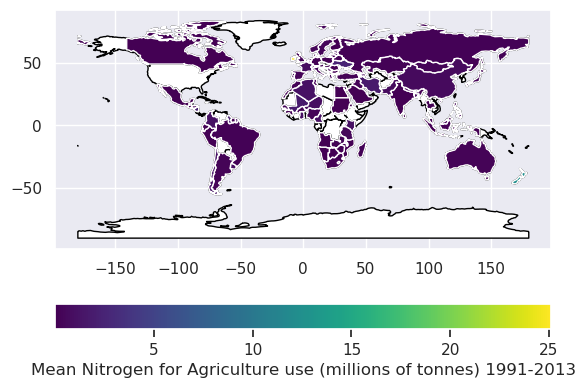

In [69]:
plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_nitrogen.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Nitrogen for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()